# 🏡Entendendo o Mercado Imobiliário de Fortaleza/CE
Com um Valor Geral de Vendas (VGV) de apróximadamente 8 bilhões de reais[*](https://cbic.org.br/recorde-historico-mercado-imobiliario-de-fortaleza-e-regiao-metropolitana-alcanca-valor-geral-de-vendas-de-r-85-bilhoes-em-2024/), a cidade de Fortaleza tem um mercado imobiliário forte e crescente. Com dados obtidos através do processo de *web scraping* nos sites da Imobiliária Lopes[**](lopes.com.br) e no site Chaves na Mão[***](chavesnamao.com.br) este projeto tem o objetivo de explorar o estado atual do mercado imobiliário e criar um modelo de regressão capaz de predizer o preço dos imóveis a partir de suas características.

## Objetivos
- Realizar uma análise exploratória capaz de trazer insights sobre o mercado imobiliário de Fortaleza.
- Treinar um modelo de machine learning capaz de predizer preços de apartamentos a partir de suas características.

# Conhecendo os Dados
## Dicionário de Dados
|Coluna|Descrição|
|---|---|
|`id`|Identificador único de cada registro|
|`origem`|Site de onde os dados foram coletados|
|`tipo`|Tipo de imóvel|
|`localizacao`|Bairro de Fortaleza/CE|
|`area`|Área em metros quadrados|
|`quartos`|Número de quartos|
|`banheiros`|Número de banheiros|
|`vagas`|Número de vagas de garagem|
|`condo`|Valor em R$ do condomínio|
|`preco`|Valor de anúncio em R$|
|`preco_m2`|Valor do metro quadrado construído em R$ (Preço/Área)|
|`timestamp_extracao`|Timestamp da extração dos dados|

## Preparação do ambiente

In [207]:
# Manipulação de dados
import pandas as pd
import numpy as np
import duckdb
from sqlalchemy import create_engine

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Notebook config
import warnings
warnings.filterwarnings('ignore')
palette = ['#0a369d', '#4472ca', '#5e7ce2', '#92b4f4', '#cfdee7']
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [208]:
engine = create_engine('sqlite:///../data/imv_database.db')
df = pd.read_sql("SELECT * FROM raw_imoveis WHERE tipo = 'Apartamento'", engine)

## Qualidade dos dados

In [209]:
# Vou remover colunas que não serão utilizadas durante a análise
df = df.drop(columns = ['id', 'origem', 'timestamp_extracao', 'tipo'])

In [210]:
df.head()

,localizacao,area,quartos,banheiros,vagas,condo,preco,preco_m2
0,Meireles,253,5,6,5,0.0,4194400.0,16578.66
1,Mucuripe,333,4,5,4,3000.0,3200000.0,9609.61
2,Meireles,66,2,2,1,0.0,1990000.0,30151.52
3,Engenheiro Luciano Cavalcante,44,1,1,1,577.0,450000.0,10227.27
4,Passaré,63,3,2,2,436.0,420000.0,6666.67


In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   localizacao  3025 non-null   object 
 1   area         3025 non-null   int64  
 2   quartos      3025 non-null   int64  
 3   banheiros    3025 non-null   int64  
 4   vagas        3025 non-null   int64  
 5   condo        3025 non-null   float64
 6   preco        3025 non-null   float64
 7   preco_m2     3025 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 189.2+ KB


In [212]:
print(f"O dataset tem {df.shape[0]} linhas, e {df.shape[1]} colunas.")

O dataset tem 3025 linhas, e 8 colunas.


In [213]:
print(f"O dataset possui {len(df.select_dtypes(include='number').columns)} colunas numéricas.")
print(f"O dataset possui {len(df.select_dtypes(exclude='number').columns)} colunas categóricas.")

O dataset possui 7 colunas numéricas.
O dataset possui 1 colunas categóricas.


In [214]:
print(f"O dataset possui {df.isnull().sum().sum()} dados nulos.")
print(f"O dataset possui {df.duplicated().sum()} dados duplicados.")

O dataset possui 0 dados nulos.
O dataset possui 69 dados duplicados.


In [215]:
# Remoção de dados duplicados
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)

In [216]:
df.nunique().sort_values()

quartos           7
banheiros         8
vagas            14
localizacao      96
area            313
condo           627
preco           958
preco_m2       2298
dtype: int64

### Estatísticas descritivas

In [217]:
df.select_dtypes(include='number').describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
area,2956.0,118.60,90.25,34.00,64.00,92.00,136.00,940.00
quartos,2956.0,2.88,0.77,1.00,2.00,3.00,3.00,7.00
banheiros,2956.0,2.91,1.35,1.00,2.00,3.00,4.00,8.00
vagas,2956.0,2.12,5.31,0.00,1.00,2.00,2.00,283.00
condo,2956.0,1383.47,20621.72,0.00,220.00,646.50,1100.00,898000.00
preco,2956.0,995049.57,1329154.40,80000.00,350000.00,620000.00,1041250.00,17070800.00
preco_m2,2956.0,7756.95,4198.12,718.09,4458.24,6989.36,10147.06,30151.52


Como esperado em um dataset que trata do mercado imobiliário, diversos outliers vão surgir especialmente no preço. Aqui podemos ver uma grande diferença nos terceiros quartis de todas as variáveis para o valor máximo, indicando outliers em todas as colunas numéricas. 

Mas algo que parece bem fora do normal são condomínios com valores tão altos como R$ 898.000,00 (não faz sentido). Além de um imóvel com 283 vagas de garagem. 

### Identificação de outliers

In [218]:
def outlier_check(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

In [219]:
for col in df.select_dtypes(include='number').columns.tolist():
    print(f"A coluna {col} tem {len(outlier_check(df, col))} outliers.")

A coluna area tem 231 outliers.
A coluna quartos tem 58 outliers.
A coluna banheiros tem 3 outliers.
A coluna vagas tem 326 outliers.
A coluna condo tem 139 outliers.
A coluna preco tem 280 outliers.
A coluna preco_m2 tem 40 outliers.


In [220]:
def plot_box(df, x, title, xaxis_title):
    fig = px.box(
        df, 
        x = x,
        color_discrete_sequence=palette 
    )
    fig.update_layout(
        title = title,
        xaxis_title = xaxis_title,
        title_font={'size': 22},
        width=1200,
        height=600
    )

    return fig.show(renderer='png')

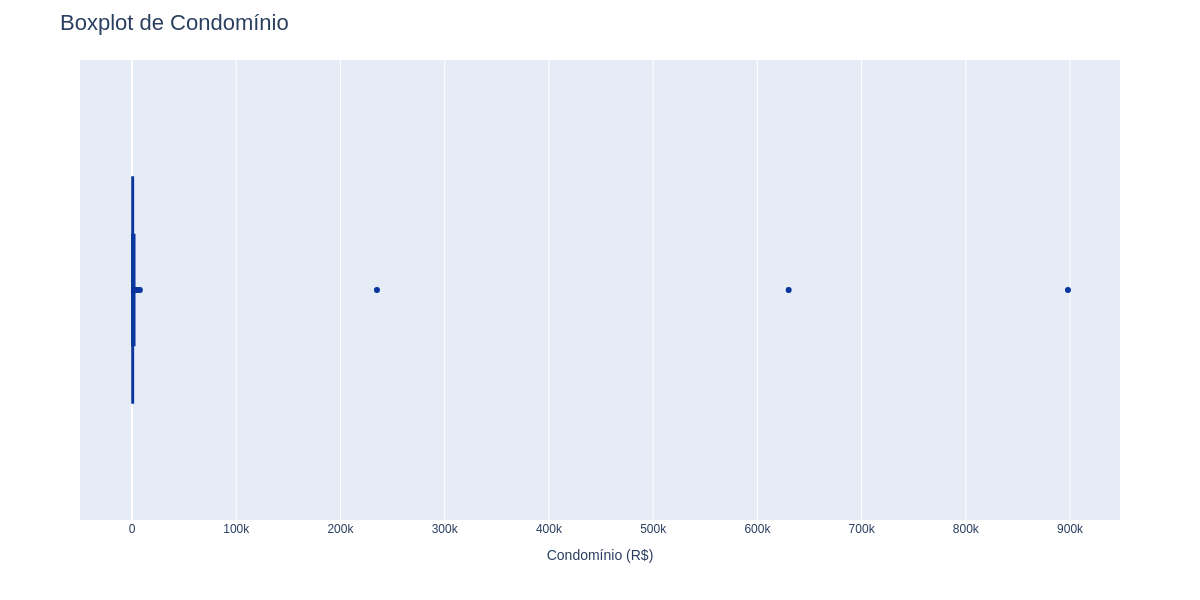

In [221]:
plot_box(df, 'condo', 'Boxplot de Condomínio', 'Condomínio (R$)')

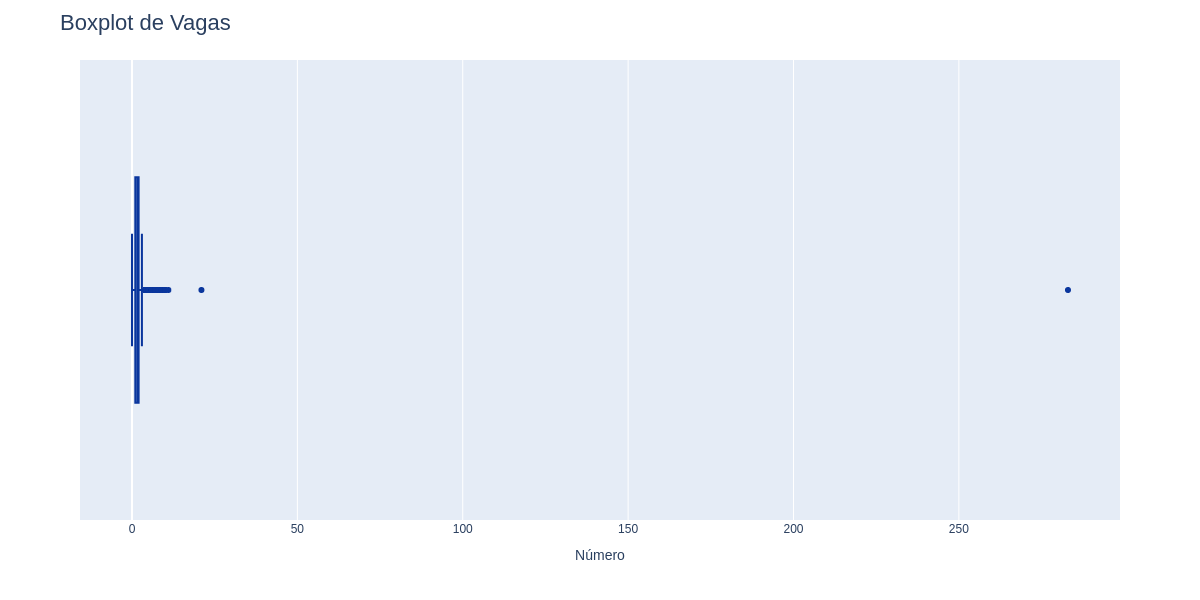

In [222]:
plot_box(df, 'vagas', 'Boxplot de Vagas', 'Número')

In [223]:
duckdb.sql("SELECT * FROM df WHERE vagas > 15 OR condo > 200000")

┌───────────────────────┬───────┬─────────┬───────────┬───────┬──────────┬───────────┬──────────┐
│      localizacao      │ area  │ quartos │ banheiros │ vagas │  condo   │   preco   │ preco_m2 │
│        varchar        │ int64 │  int64  │   int64   │ int64 │  double  │  double   │  double  │
├───────────────────────┼───────┼─────────┼───────────┼───────┼──────────┼───────────┼──────────┤
│ Planalto Ayrton Senna │    38 │       2 │         1 │   283 │      0.0 │  204000.0 │  5368.42 │
│ Parque Iracema        │    70 │       3 │         2 │     2 │ 630000.0 │  640000.0 │  9142.86 │
│ Meireles              │   220 │       3 │         4 │    21 │   2400.0 │ 4500000.0 │ 20454.55 │
│ Varjota               │   120 │       3 │         3 │     2 │ 898000.0 │  690000.0 │   5750.0 │
│ Prefeito José Walter  │    44 │       2 │         2 │     1 │ 235000.0 │  325000.0 │  7386.36 │
└───────────────────────┴───────┴─────────┴───────────┴───────┴──────────┴───────────┴──────────┘

In [224]:
# Vamos eliminar estes registros
df = duckdb.sql("SELECT * FROM df WHERE vagas < 15 AND condo < 200000").to_df()

Para facilitar a análise vou criar variáveis ordinais para estas colunas onde: 0 = 0, 1 = 1, 2 = 2, 3 =3, 4 = 4, 5 = 5+.

In [225]:
df = duckdb.sql(
    """
    SELECT
        *
        , CASE WHEN quartos >= 5 THEN 5 ELSE quartos END AS quartos_ord
        , CASE WHEN banheiros >= 5 THEN 5 ELSE banheiros END AS banheiros_ord
        , CASE WHEN vagas >= 5 THEN 5 ELSE vagas END AS vagas_ord
    FROM df
    """
).to_df()
df.head()

,localizacao,area,quartos,banheiros,vagas,condo,preco,preco_m2,quartos_ord,banheiros_ord,vagas_ord
0,Meireles,253,5,6,5,0.0,4194400.0,16578.66,5,5,5
1,Mucuripe,333,4,5,4,3000.0,3200000.0,9609.61,4,5,4
2,Meireles,66,2,2,1,0.0,1990000.0,30151.52,2,2,1
3,Engenheiro Luciano Cavalcante,44,1,1,1,577.0,450000.0,10227.27,1,1,1
4,Passaré,63,3,2,2,436.0,420000.0,6666.67,3,2,2


## Análise Exploratória de Dados
### Análises Univariadas

In [226]:
def plot_hist(df, x, title, xaxis_title, yaxis_title):
    fig = px.histogram(
        df,
        x = x,
        title=title,
        histnorm='percent',
        marginal='rug',
        nbins=50,
        color_discrete_sequence=palette
    )

    fig.update_layout(
        title_font={'size': 22},
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        bargap=0.05,
        width=1200,
        height=600
    )

    return fig.show(renderer='png')

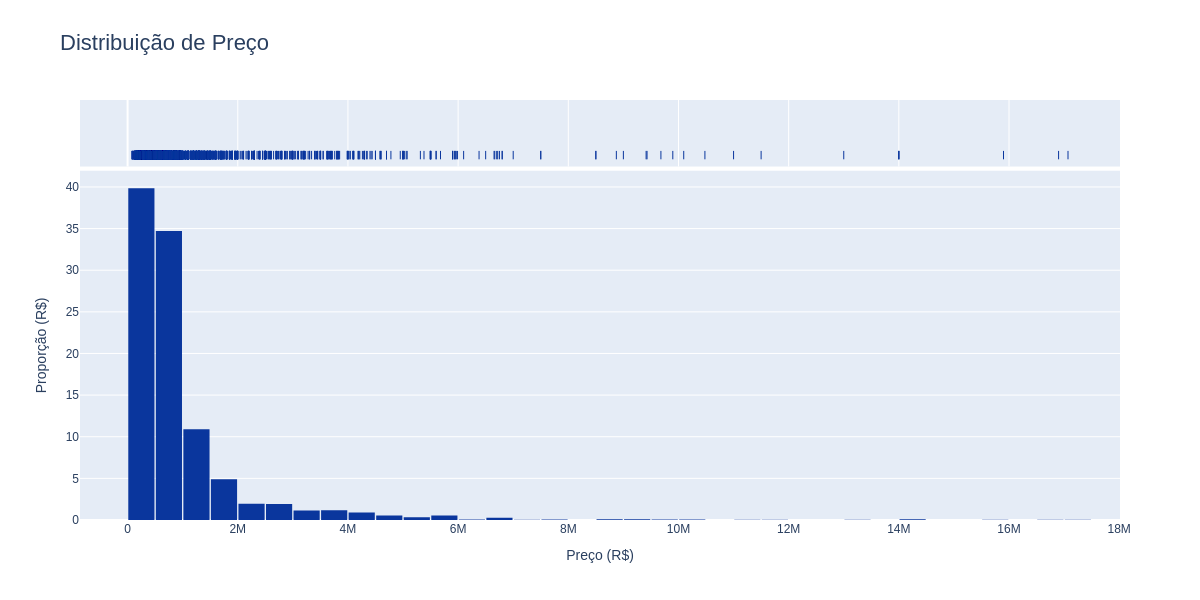

In [227]:
plot_hist(df, 'preco', 'Distribuição de Preço', 'Preço (R$)', 'Proporção (R$)')

Como esperado em um mercado onde valores tem uma grande variância, temos imóveis de altíssimo valor que causam uma assimetria na distribuição. Para uma melhor compreensão vamos visualizar a distribuição em imóveis com um limite máximo de valor de R$ 5.000.000,00. 

In [228]:
print(f"O dataset possui {len(df[df['preco']>=5_000_000])} imóveis acima de 5mi.")

O dataset possui 58 imóveis acima de 5mi.


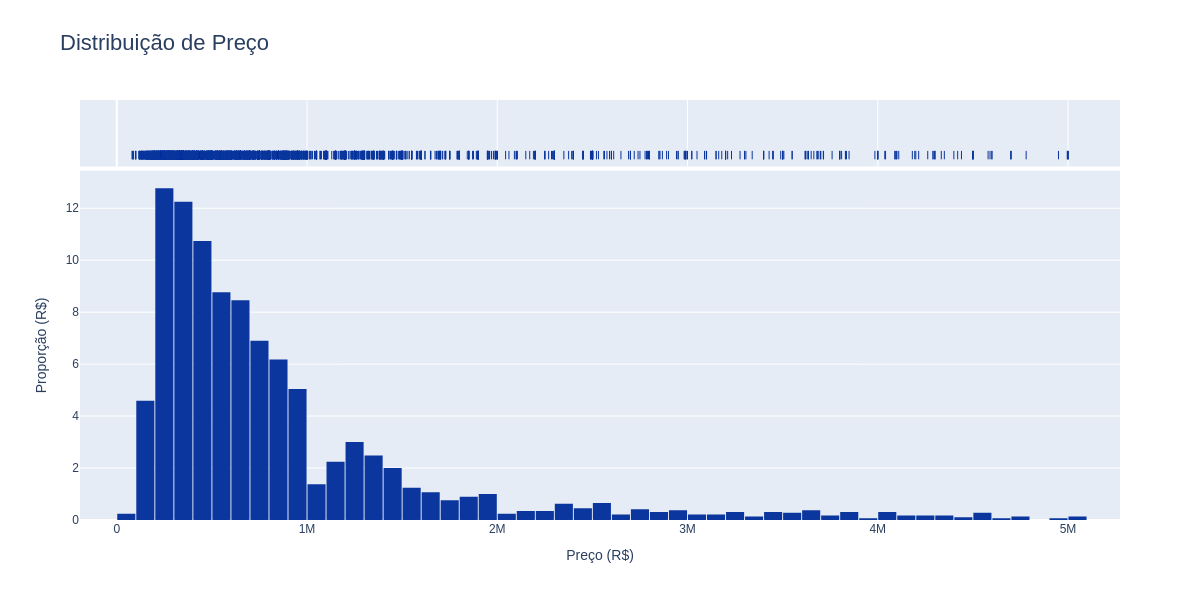

In [229]:
plot_hist(df[df['preco']<=5_000_000], 'preco', 'Distribuição de Preço', 'Preço (R$)', 'Proporção (R$)')

Com apenas 58 imóveis acima deste valor, podemos remover estes valores extremos sem perder muitas informações. 

In [230]:
df = df[df['preco']<=5_000_000]

Por fim, com uma transformação em $log$ é possível atingir uma distribuição próxima à normal para a nossa variável dependente, o que será útil durante a construção do nosso modelo de Machine Learning.

In [231]:
df['log_preco'] = np.log1p(df['preco'])

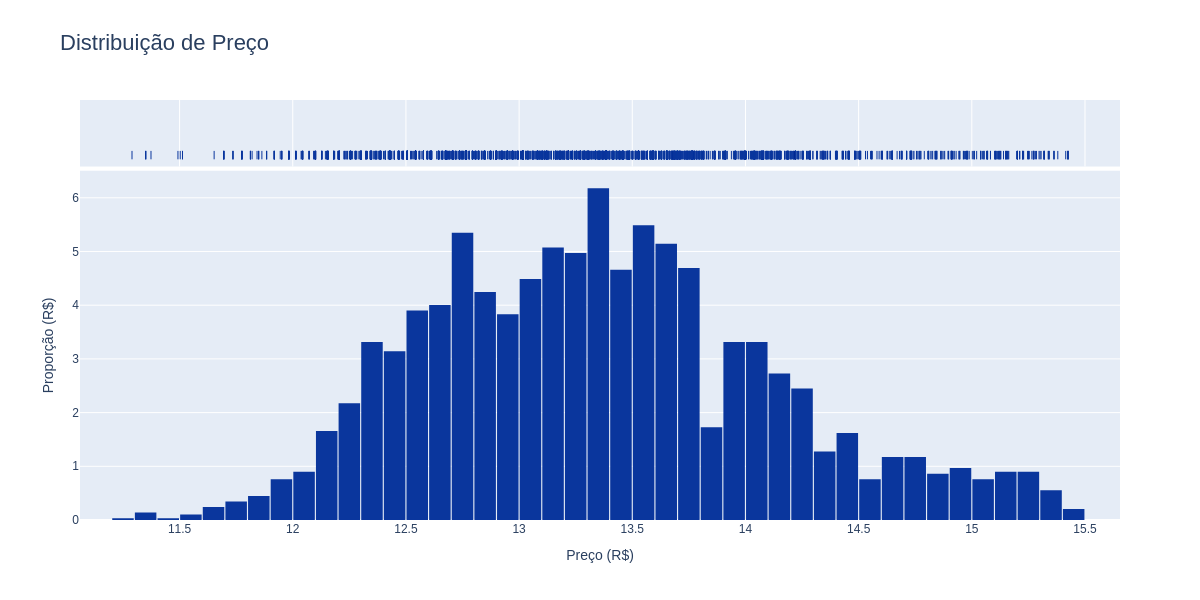

In [232]:
plot_hist(df, 'log_preco', 'Distribuição de Preço', 'Preço (R$)', 'Proporção (R$)')

Agora vamos partir para outras variáveis

In [249]:
def plot_bar(df:pd.DataFrame, x:str, title:str, xaxis_title:str, yaxis_title:str):
    fig = px.histogram(
        df,
        x =x,
        title=title,
        histnorm='percent',
        color_discrete_sequence=palette
    )

    fig.update_layout(
        title_font={'size': 22},
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        bargap=0.05,
        width=1200,
        height=600
    )

    return fig.show(renderer='png')

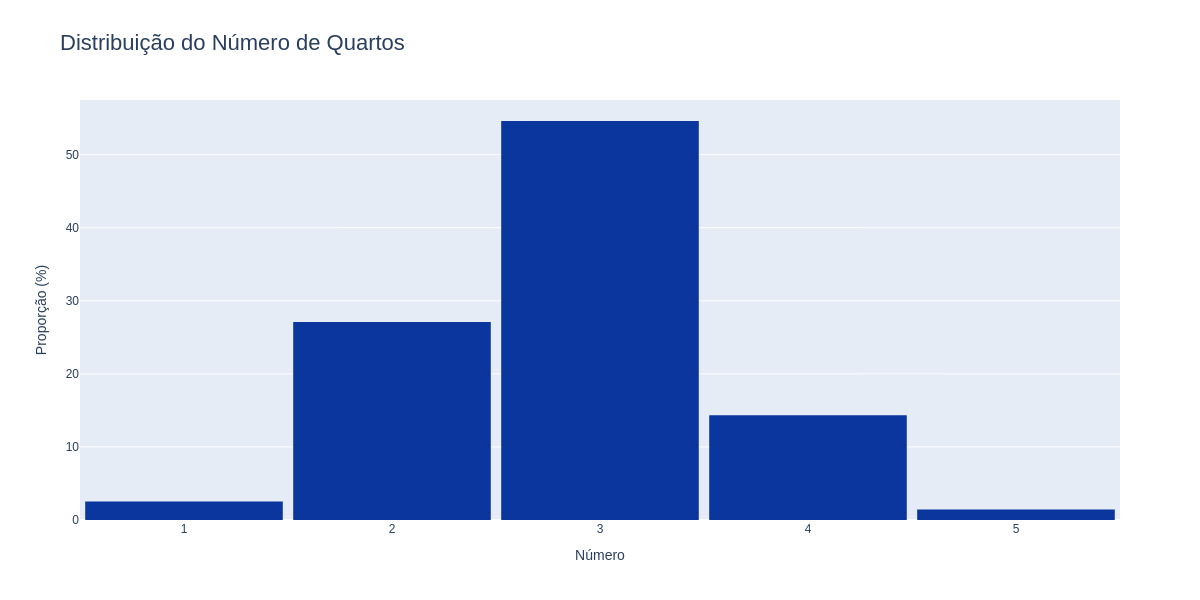

In [250]:
plot_bar(df, 'quartos_ord', 'Distribuição do Número de Quartos', 'Número', 'Proporção (%)')

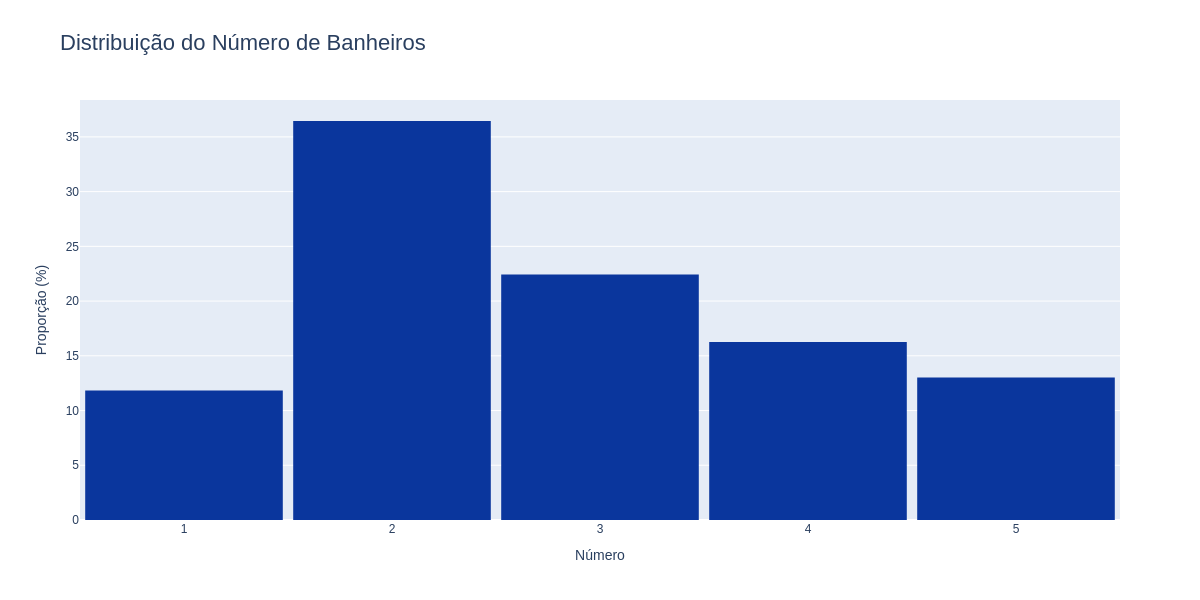

In [251]:
plot_bar(df, 'banheiros_ord', 'Distribuição do Número de Banheiros', 'Número', 'Proporção (%)')

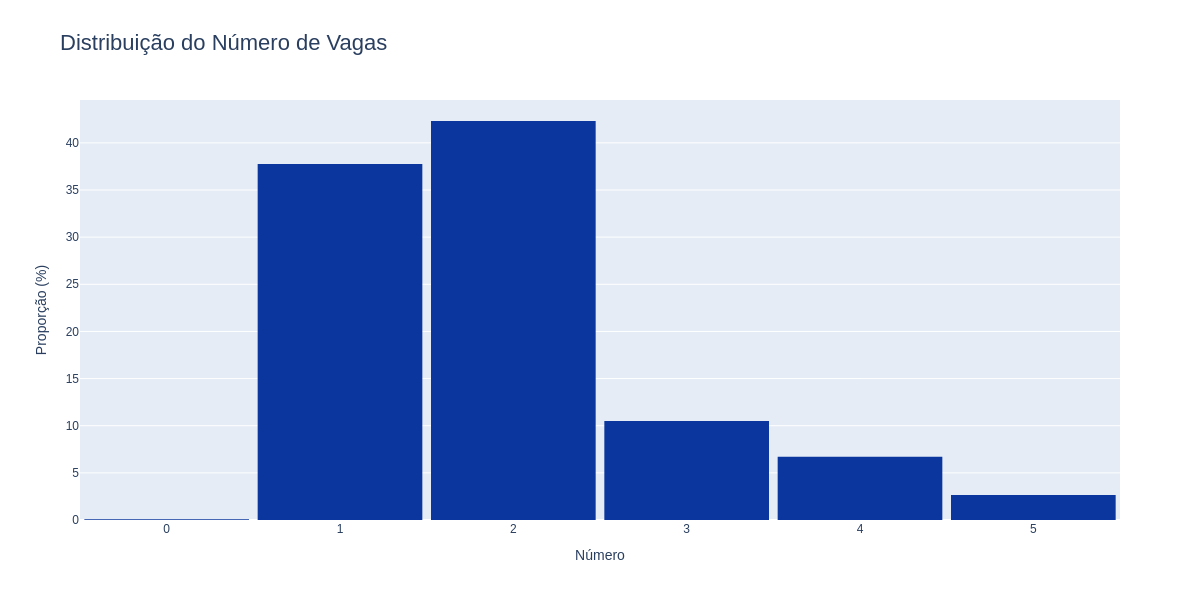

In [252]:
plot_bar(df, 'vagas_ord', 'Distribuição do Número de Vagas', 'Número', 'Proporção (%)')

### Análise Multivariadas